In [ ]:
from urllib.request import urlopen
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import shap
import seaborn as sns


In [ ]:
df = pickle.load(urlopen('https://drive.usercontent.google.com/u/0/uc?id=1hN_1LAMCoyRu_WXzSj1k9kOmM98zgiBm&export=download'))
df

,Date,Actual Price,Forecasted Load,Cleared Load,Actual Load,Retail Price(cents/kwhr),kwhrs,Precipitation (in) Chicago,Snowfall (in) Chicago,Max Temp (F) Chicago,...,Precipitation (in) Springfield,Snowfall (in) Springfield,Max Temp (F) Springfield,Min Temp (F) Springfield,Mean Temp (F) Springfield,Average Max Temp (F),Average Min Temp (F),Average Mean Temp (F),Average Precipitation (in),Average Snowfall (in)
0,2023-10-20 16:00:00,41.50,71410,72599,73812,15.75,2.634921,0.0,0.0,61.0,...,0.00,0.0,68.0,45.0,56.5,62.666667,46.333333,54.500000,0.083333,0.0
1,2023-10-20 17:00:00,92.50,71201,73940,73858,15.75,5.873016,0.0,0.0,61.0,...,0.00,0.0,68.0,45.0,56.5,62.666667,46.333333,54.500000,0.083333,0.0
2,2023-10-20 18:00:00,31.93,71200,76048,73281,15.75,2.027302,0.0,0.0,61.0,...,0.00,0.0,68.0,45.0,56.5,62.666667,46.333333,54.500000,0.083333,0.0
3,2023-10-20 19:00:00,26.58,71319,77348,73087,15.75,1.687619,0.0,0.0,61.0,...,0.00,0.0,68.0,45.0,56.5,62.666667,46.333333,54.500000,0.083333,0.0
4,2023-10-20 20:00:00,27.59,70508,73893,71105,15.75,1.751746,0.0,0.0,61.0,...,0.00,0.0,68.0,45.0,56.5,62.666667,46.333333,54.500000,0.083333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,2024-07-31 18:00:00,50.56,117585,117182,115967,15.35,3.293811,0.0,0.0,92.0,...,0.32,0.0,82.0,70.0,76.0,87.333333,70.000000,78.666667,0.106667,0.0
6428,2024-07-31 19:00:00,27.55,115484,116193,112798,15.35,1.794788,0.0,0.0,92.0,...,0.32,0.0,82.0,70.0,76.0,87.333333,70.000000,78.666667,0.106667,0.0
6429,2024-07-31 20:00:00,32.36,111855,114754,108578,15.35,2.108143,0.0,0.0,92.0,...,0.32,0.0,82.0,70.0,76.0,87.333333,70.000000,78.666667,0.106667,0.0
6430,2024-07-31 21:00:00,35.01,108298,109081,105087,15.35,2.280782,0.0,0.0,92.0,...,0.32,0.0,82.0,70.0,76.0,87.333333,70.000000,78.666667,0.106667,0.0


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

df.dropna(inplace=True)

df.sort_values('Date', inplace=True)

df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Hour'] = df['Date'].dt.hour
df['Season'] = df['Date'].dt.month % 12 // 3 + 1  # winter = 1, spring = 2, summer = 3, fall = 4

In [ ]:
features = [
    'Forecasted Load',
    'Cleared Load',
    'Average Max Temp (F)',
    'Average Min Temp (F)',
    'Average Mean Temp (F)',
    'Average Precipitation (in)',
    'Average Snowfall (in)',
    'Month',
    'DayOfWeek',
    'Hour',
    'Season'
]

X = df[features]
y = df['Actual Price']

In [ ]:
X_values = X.values
y_values = y.values

groups = df['Month'].values

gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [ ]:
for train_idx, test_idx in gss.split(X_values, y_values, groups=groups):
    X_train, X_test = X_values[train_idx], X_values[test_idx]
    y_train, y_test = y_values[train_idx], y_values[test_idx]

    # scale the features
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    # scale the target
    target_scaler = MinMaxScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))

    # built
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    # compile
    model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

In [ ]:
history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_test_scaled, y_test_scaled),
        epochs=50,
        batch_size=32,
        verbose=1
    )

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0661 - val_loss: 0.0067
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0049
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 9/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 10/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 11/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 12/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [ ]:
explainer = shap.DeepExplainer(model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [ ]:
shap_values

array([[[-0.00319905],
        [ 0.00014669],
        [-0.00694479],
        ...,
        [ 0.00062775],
        [ 0.00732094],
        [-0.00912092]],

       [[ 0.00247248],
        [-0.00136973],
        [-0.01117503],
        ...,
        [-0.0019443 ],
        [ 0.00261416],
        [-0.00336391]],

       [[ 0.00411442],
        [-0.00189158],
        [-0.01005866],
        ...,
        [-0.0020935 ],
        [ 0.00037514],
        [-0.00191939]],

       ...,

       [[-0.01757432],
        [ 0.01286265],
        [ 0.00801982],
        ...,
        [-0.01282746],
        [-0.00613055],
        [-0.00695644]],

       [[-0.01517622],
        [ 0.00825331],
        [ 0.01045281],
        ...,
        [-0.01521242],
        [-0.00790565],
        [-0.00420143]],

       [[-0.01589069],
        [ 0.00498248],
        [ 0.01484382],
        ...,
        [-0.01316737],
        [-0.00644831],
        [-0.00211259]]])

In [ ]:
shap_values_flat = np.squeeze(shap_values)
shap_values_flat

array([[-0.00319905,  0.00014669, -0.00694479, ...,  0.00062775,
         0.00732094, -0.00912092],
       [ 0.00247248, -0.00136973, -0.01117503, ..., -0.0019443 ,
         0.00261416, -0.00336391],
       [ 0.00411442, -0.00189158, -0.01005866, ..., -0.0020935 ,
         0.00037514, -0.00191939],
       ...,
       [-0.01757432,  0.01286265,  0.00801982, ..., -0.01282746,
        -0.00613055, -0.00695644],
       [-0.01517622,  0.00825331,  0.01045281, ..., -0.01521242,
        -0.00790565, -0.00420143],
       [-0.01589069,  0.00498248,  0.01484382, ..., -0.01316737,
        -0.00644831, -0.00211259]])

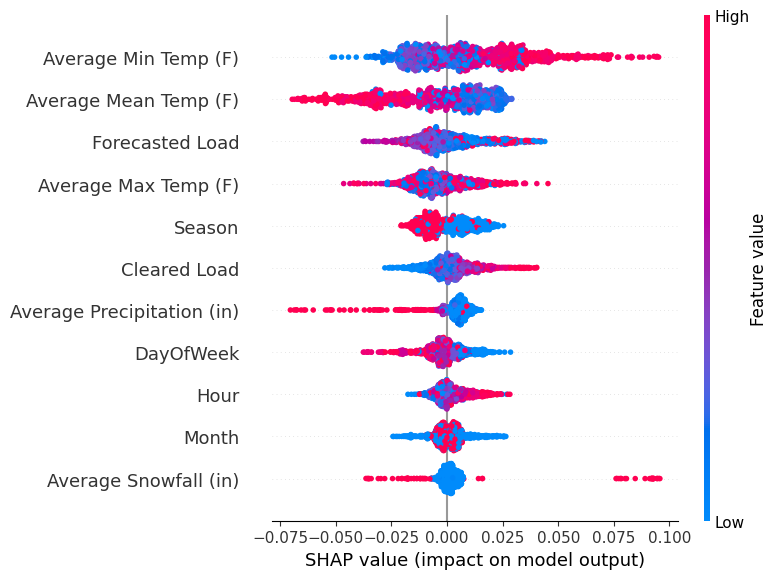

In [ ]:
shap.summary_plot(shap_values_flat, X_test_scaled, feature_names=features)


The SHAP library was used to compute feature importance. Because of the large dataset used in our model, it was difficult to compute the *actual* Shapley values for our features directly, such as with the KernelExplainer class. Instead, the DeepExplainer class was used to approximate the Shapley values.

The plot above shows the most important (from the top) to least important (towards the bottom) features used to create our model. It shows that the cleared and forecasted load is the biggest driver in determining the actual energy price.

We also see strong correlations from the minimum temperature.

Our model currently makes prediction based on 3 temperature datapoints, however, the plot above hints that the triad of weather datapoints (mean, min, max) might be working against each other and that the model could perhaps be improved by picking just one.

This analysis also shows that we see little impact from precipitation amounts.



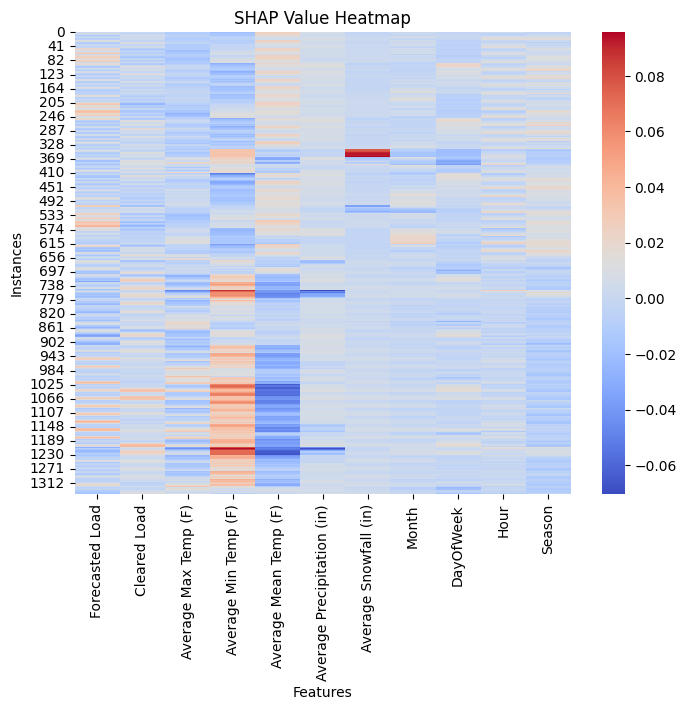

In [ ]:
shap_df = pd.DataFrame(shap_values_flat, columns=features)
plt.figure(figsize=(8, 6))
sns.heatmap(shap_df, cmap="coolwarm", annot=False, fmt=".2f", cbar=True)
plt.title("SHAP Value Heatmap")
plt.xlabel("Features")
plt.ylabel("Instances")
plt.show()